# Credit Card Anamoly Detection





### Dataset Information
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1 - Data Preprocessing

### Importing the dataset

In [3]:
data = pd.read_csv('creditcard.csv')
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Exploratory Data Analysis

In [5]:
data.isnull().sum(axis=1)

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Length: 284807, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Frequency')

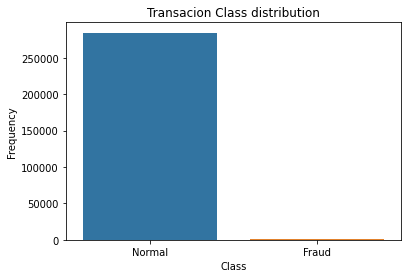

In [6]:
sns.countplot(data['Class'])
plt.title('Transacion Class distribution')
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Frequency')

In [7]:
pd.value_counts(data['Class'])

0    284315
1       492
Name: Class, dtype: int64

In [8]:
#Determine the number of fraud and valid transactions in the dataset
Fraud = data[data['Class'] == 1]
Normal = data[data['Class'] == 0]
outlier_fraction = len(Fraud)/float(len(Normal))

In [9]:
print(Fraud.shape, Normal.shape)
print(outlier_fraction)

(492, 31) (284315, 31)
0.0017304750013189597


In [10]:
Fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
Normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

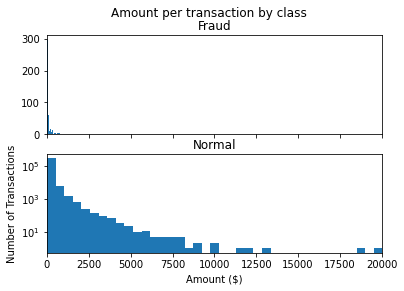

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

In [16]:
data_sample = data.sample(frac=0.1, random_state = 1)
data_sample.shape

(28481, 31)

## Correlation Matrix

<AxesSubplot:>

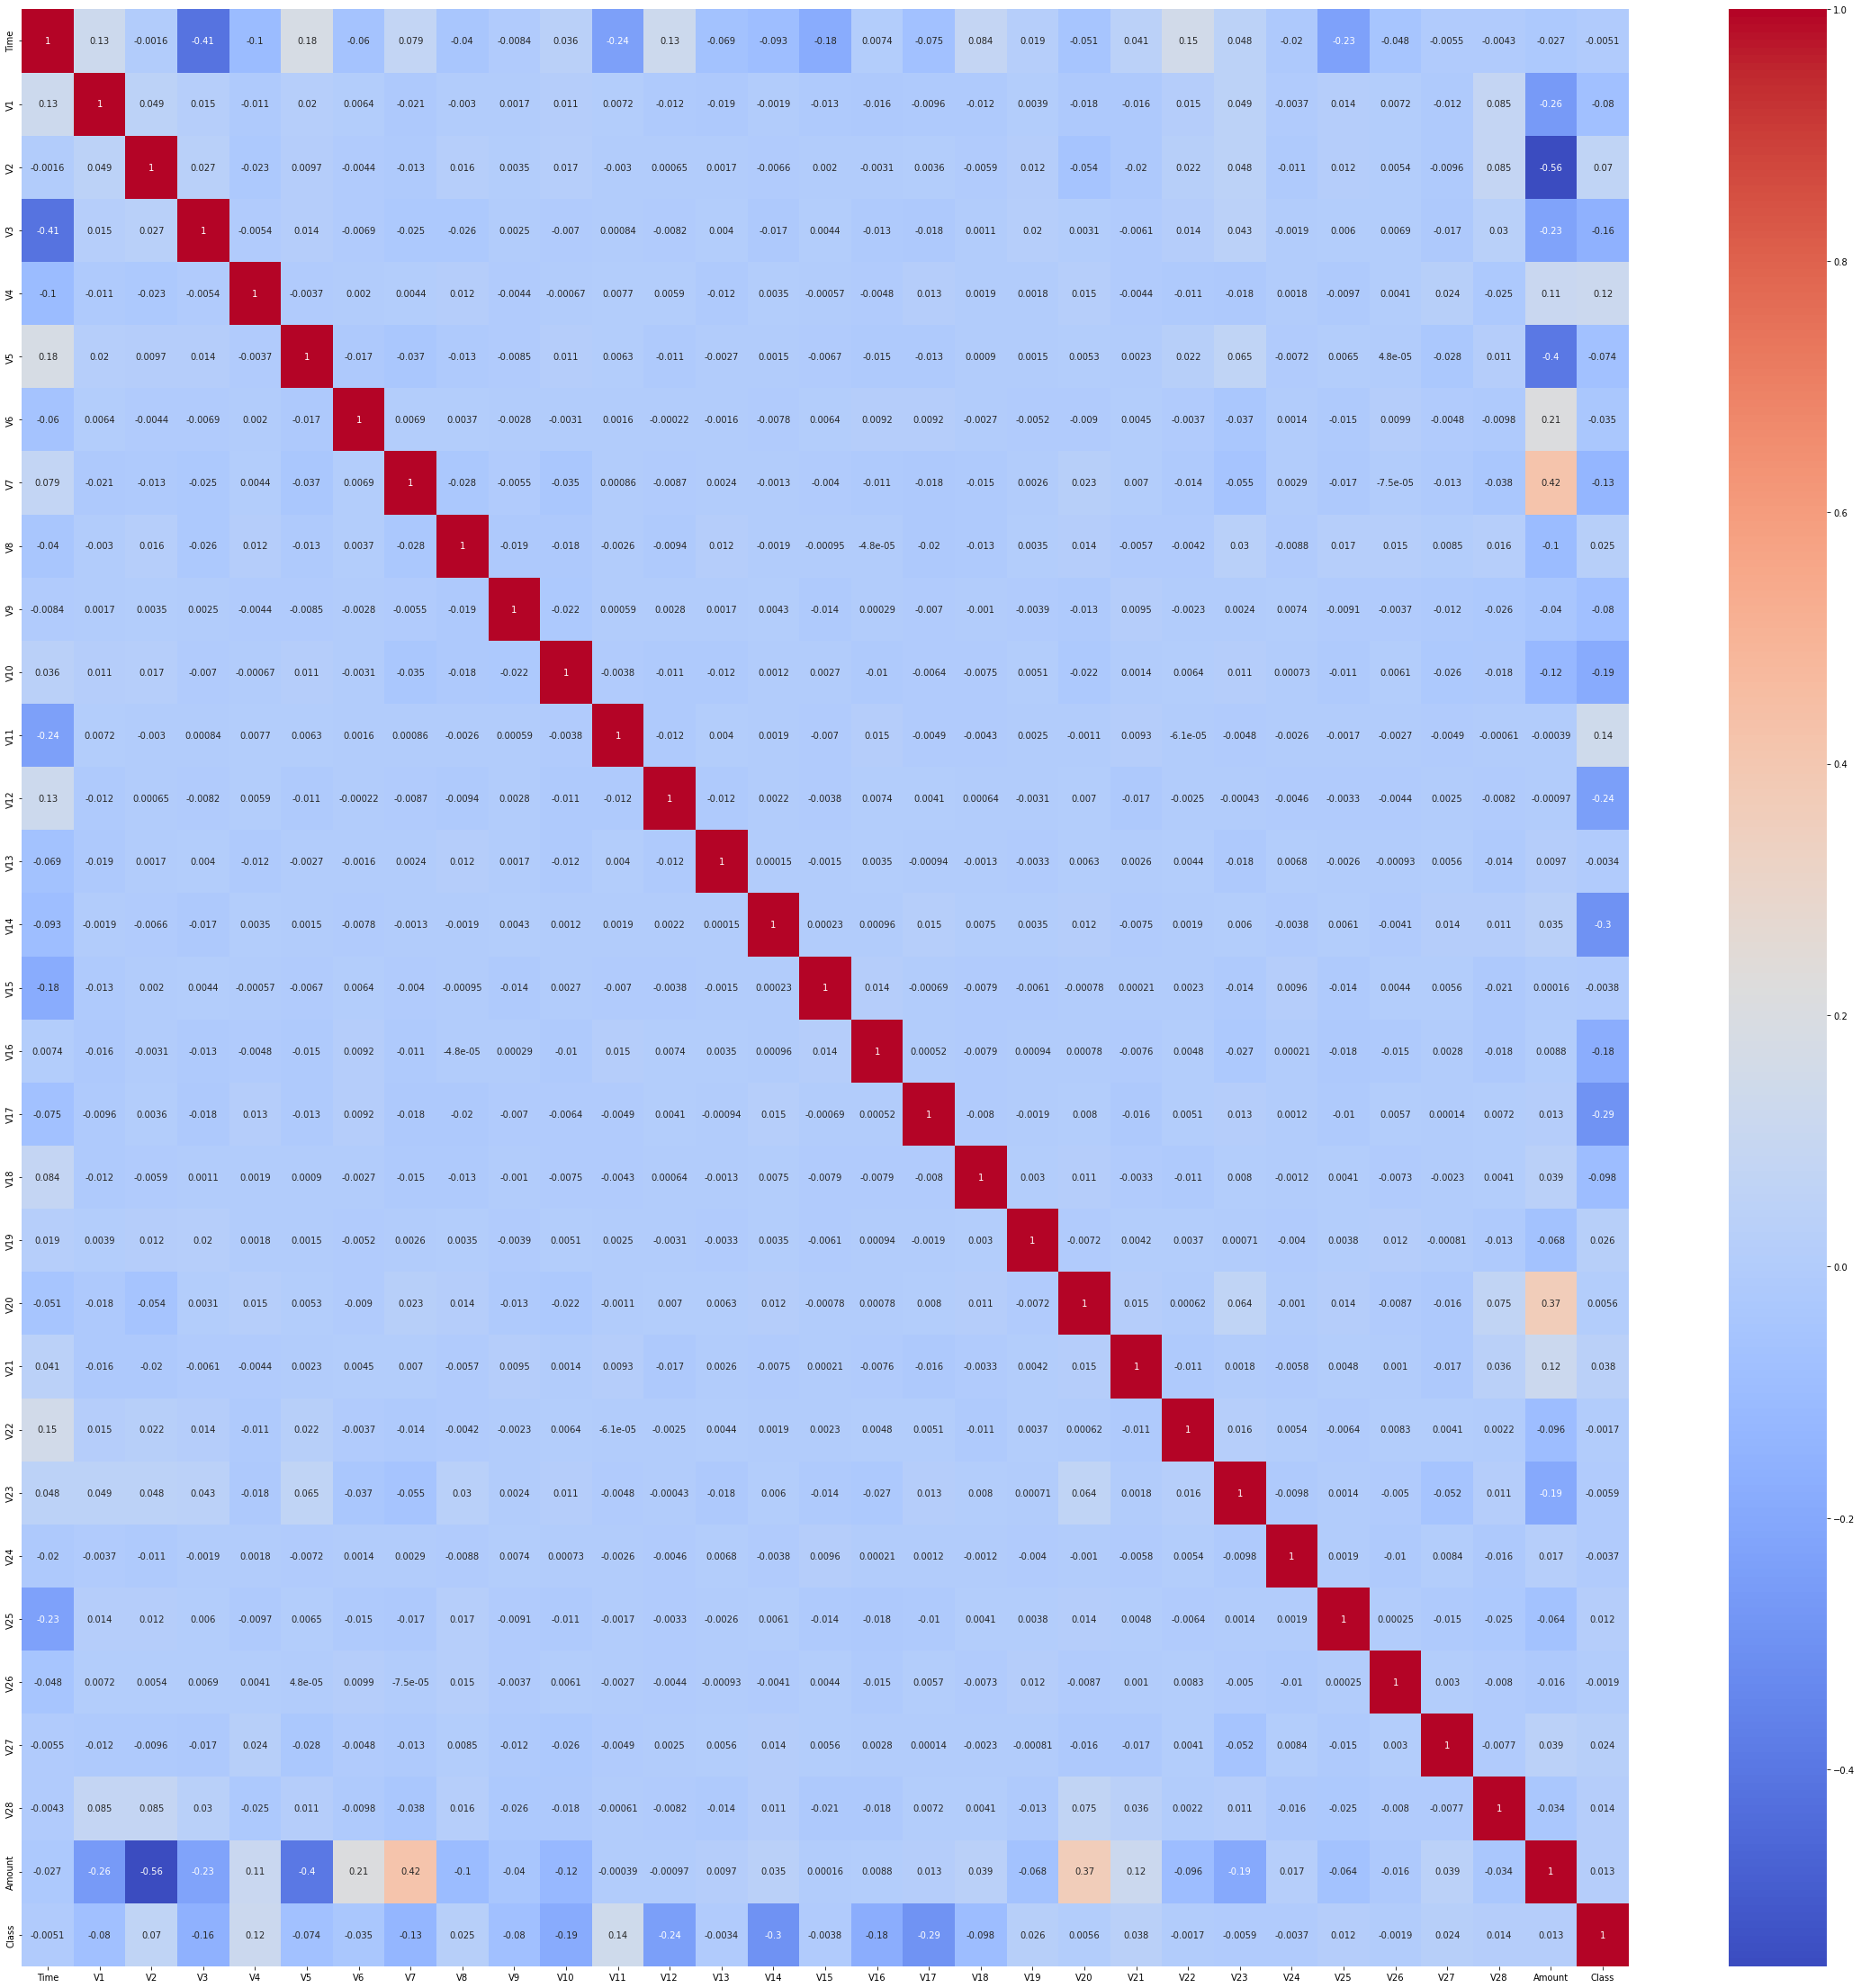

In [17]:
corr = data_sample.corr()
plt.figure(figsize = (40,40))
sns.heatmap(corr, annot = True, cmap='coolwarm')

In [18]:
#Creating independent and dependent Features
X = data_sample.drop('Class', axis = 1)
y = data_sample['Class']
print(f"X_shape = {X.shape}, y_shape = {y.shape}")

X_shape = (28481, 30), y_shape = (28481,)


## Standard Scaling

In [19]:
#Standarization the data.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaler = ss.fit_transform(X)

In [20]:
X_scaler

array([[ 0.52963227, -0.30610711, -0.43967593, ...,  0.16301852,
         0.70057649, -0.32547501],
       [-0.34391965, -0.40786542,  0.78261735, ...,  0.39234378,
         0.19776905, -0.32477362],
       [-0.25897493, -0.15895241,  0.66523949, ...,  0.59942742,
         0.30055258, -0.32879739],
       ...,
       [-1.92367694, -0.1576219 ,  0.62760708, ...,  0.46911678,
         0.52914068, -0.25972873],
       [ 0.08504905, -1.79445897,  2.41027326, ...,  1.88169238,
         1.11069978, -0.32868665],
       [-0.5993212 ,  0.60888234,  0.1436275 , ..., -0.00942907,
         0.06701383, -0.26068853]])

# Model Prediction

Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

1. Isolation Forest Alogorithm
2. Local Outlier Factor(LOF) Algorithm

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [22]:
#splitting into train test data
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size = 0.3, random_state = 42, stratify = y)#unbiased

In [23]:
#create a class for different methods used for detecting the outliers and the Anamoly detection
classifiers_1 = {
    "Isolation_Forest_Algorithm" : IsolationForest(n_estimators=100, max_samples= len(X),contamination = outlier_fraction, random_state = 42, verbose = 0),
    "Local_Outlier_Factor": LocalOutlierFactor(n_neighbors = 20, algorithm = "auto", leaf_size = 30, metric = "minkowski", p=2, metric_params = None, contamination = outlier_fraction),
    "Support_Vector_Machine": OneClassSVM(kernel = "rbf", degree =3, gamma=0.1, nu = 0.5, max_iter = -1, )
    }

In [24]:
#create a class for different methods
classifiers_2 = {
    "Logistic_Regression": LogisticRegression(random_state=42),
    "Random_Forest_Classifier": RandomForestClassifier(n_estimators=100, random_state = 42),
    }

In [25]:
classifiers_1.items()

dict_items([('Isolation_Forest_Algorithm', IsolationForest(contamination=0.0017304750013189597, max_samples=28481,
                random_state=42)), ('Local_Outlier_Factor', LocalOutlierFactor(contamination=0.0017304750013189597)), ('Support_Vector_Machine', OneClassSVM(gamma=0.1))])

In [26]:
classifiers_2.items()

dict_items([('Logistic_Regression', LogisticRegression(random_state=42)), ('Random_Forest_Classifier', RandomForestClassifier(random_state=42))])

In [27]:
from sklearn.metrics import classification_report,accuracy_score

In [29]:
#training it over the whole dataset without splitting into training and testing data.
for i, (classifier_name, classifier) in enumerate(classifiers_1.items()):

  if classifier_name == "Local_Outlier_Factor":
    y_pred = classifier.fit_predict(X_scaler) 

  elif classifier_name == "Support_Vector_Machine":
    classifier.fit(X_scaler)
    y_pred = classifier.predict(X_scaler)  
  else:
    classifier.fit(X_scaler)
    y_pred = classifier.predict(X_scaler)  
  
    
  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1
  n_errors = (y_pred != y).sum()
  print("{}: {}".format(classifier_name,n_errors))
  print("Accuracy Score :")
  print(accuracy_score(y,y_pred))
  print("Classification Report :")
  print(classification_report(y,y_pred))
  print("F1 Score:",f1_score(y, y_pred))
  print("\n-------------------------------------\n")

Isolation_Forest_Algorithm: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

F1 Score: 0.2626262626262626

-------------------------------------

Local_Outlier_Factor: 95
Accuracy Score :
0.9966644429619747
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.04      0.04      0.04        49

    accuracy                           1.00     28481
   macro avg       0.52      0.52      0.52     28481
weighted avg       1.00      1.00      1.00     28481

F1 Score: 0.0404040404040404

-------------------------------------

Support_Vector_Machine: 14193
Ac

In [30]:
for i, (classifier_name, classifier) in enumerate(classifiers_2.items()):
  if classifier_name == "Logistic_Regression":
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

  elif classifier_name == "Random_Forest_Classifier":
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
  

  n_errors = (y_pred != y_test).sum()
  print("{}: {}".format(classifier_name,n_errors))
  print("Accuracy Score :")
  print(accuracy_score(y_test,y_pred))
  print("Classification Report :")
  print(classification_report(y_test,y_pred))
  print("F1 Score:",f1_score(y_test, y_pred))
  print("\n-------------------------------------\n")

Logistic_Regression: 10
Accuracy Score :
0.9988297249853716
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.78      0.47      0.58        15

    accuracy                           1.00      8545
   macro avg       0.89      0.73      0.79      8545
weighted avg       1.00      1.00      1.00      8545

F1 Score: 0.5833333333333334

-------------------------------------

Random_Forest_Classifier: 6
Accuracy Score :
0.9992978349912229
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       1.00      0.60      0.75        15

    accuracy                           1.00      8545
   macro avg       1.00      0.80      0.87      8545
weighted avg       1.00      1.00      1.00      8545

F1 Score: 0.7499999999999999

-------------------------------------



In [31]:
#Lets try model boosting technique
from xgboost import XGBClassifier
classifier = XGBClassifier(n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Classification Report :")
print(classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       1.00      0.60      0.75        15

    accuracy                           1.00      8545
   macro avg       1.00      0.80      0.87      8545
weighted avg       1.00      1.00      1.00      8545

F1 Score: 0.7499999999999999


# Class Imbalancement

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Frequency')

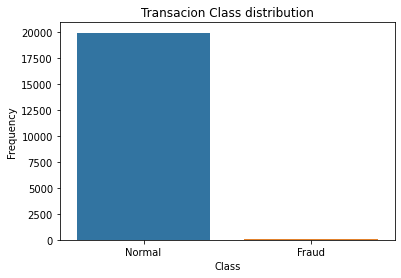

In [33]:
sns.countplot(y_train)
plt.title('Transacion Class distribution')
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Frequency')

In [35]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
# Using SMOTE technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input.
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()
X_smote, y_smote = over_sample.fit_resample(X_train, y_train)
X_df, y_df = over_sample.fit_resample(X_scaler, y)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Frequency')

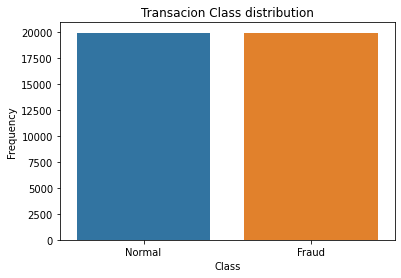

In [39]:
sns.countplot(y_smote)
plt.title('Transacion Class distribution')
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.xlabel('Class')
plt.ylabel('Frequency')

In [40]:
for i, (classifier_name, classifier) in enumerate(classifiers_2.items()):
  if classifier_name == "Logistic_Regression":
    classifier.fit(X_smote, y_smote)
    y_pred = classifier.predict(X_test)

  elif classifier_name == "Random_Forest_Classifier":
    classifier.fit(X_smote, y_smote)
    y_pred = classifier.predict(X_test) 
  

  n_errors = (y_pred != y_test).sum()
  print("{}: {}".format(classifier_name,n_errors))
  print("Accuracy Score :")
  print(accuracy_score(y_test,y_pred))
  print("Classification Report :")
  print(classification_report(y_test,y_pred))
  print("F1 Score:",f1_score(y_test, y_pred))
  print("\n-------------------------------------\n")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression: 132
Accuracy Score :
0.9845523698069046
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8530
           1       0.09      0.80      0.15        15

    accuracy                           0.98      8545
   macro avg       0.54      0.89      0.57      8545
weighted avg       1.00      0.98      0.99      8545

F1 Score: 0.15384615384615383

-------------------------------------

Random_Forest_Classifier: 6
Accuracy Score :
0.9992978349912229
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.91      0.67      0.77        15

    accuracy                           1.00      8545
   macro avg       0.95      0.83      0.88      8545
weighted avg       1.00      1.00      1.00      8545

F1 Score: 0.7692307692307692

-------------------------------------



Observations :


*  Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors versus Logistic_Regression detecting 10 errors versus Random_Forest_Classifier detecting 6 errors before applying SMOTE.
*   After applying SMOTE technique, Logistic_Regression detecting 132 errors versus Random_Forest_Classifier detecting 6 errors.
*   Isolation Forest has a 99.74% more accurate than LOF of 99.66%, SVM of 50.12%, Logistic_Regression has a 98.45% and Random_Forest_Classifier has a 99.93% accuracy. When comparing error precision & recall for 5 models , the Random_Forest_Classifier and Isolation Forest performed much better than the LOF and rest as we can see that the detection of fraud cases in Random Forest is around 77% versus Logistic Regression is around 15.3% versus Isolation Forest is around 26.2 % versus LOF detection rate of just 4 % and SVM of 0.66%.
* So overall Random Forest Method and then Isolation Forest performed much better in determining the fraud cases which is around 77% and 26.2% then others.
* We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases.